In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
for dirname, _, filenames in os.walk('.\data'):
    for filename in filenames:
        print os.path.join(dirname, filename)

.\data\items.csv
.\data\items_new.csv
.\data\item_categories.csv
.\data\item_categories_new.csv
.\data\sales_train.csv
.\data\sales_train_new.csv
.\data\sample_submission.csv
.\data\shops.csv
.\data\shops_new.csv
.\data\test.csv


In [17]:
items=pd.read_csv('.\data\items_new.csv', index_col=0)
item_categories=pd.read_csv('.\data\item_categories_new.csv', index_col=0)
shops=pd.read_csv('.\data\shops_new.csv', index_col=0)
test=pd.read_csv('.\data\\test.csv', index_col='ID')

sales_train=pd.read_csv('.\data\sales_train_new.csv', index_col=0)
sample_submission=pd.read_csv('.\data\sample_submission.csv')

In [12]:
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [13]:
item_categories.head()

,item_category_id,glob_item_category
0,0,PC
1,1,Аксессуары
2,2,Аксессуары
3,3,Аксессуары
4,4,Аксессуары


In [14]:
shops.head()

,shop_id,city
2,2,Адыгея
3,3,Балашиха
4,4,Волжский
5,5,Вологда
6,6,Воронеж


In [15]:
sales_train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,day,year
0,0,59,22154,999.00,1.0,1,2,2013
1,0,25,2552,899.00,1.0,1,3,2013
2,0,25,2552,899.00,-1.0,1,5,2013
3,0,25,2554,1709.05,1.0,1,6,2013
4,0,25,2555,1099.00,1.0,1,15,2013


In [18]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


# 1) Агрегирование данных продаж по месяцам

Так как задача стоит предсказать колличество продаж по месяцам, то мы агрегируем данные по всем магазинам и товарам по признаку item_cnt_day, создав новый признак item_cnt_month

In [22]:
sales_train_ag=pd.DataFrame()
sales_train_ag=sales_train.groupby(["date_block_num","shop_id","item_id","month","item_price", 'year'],as_index=False).sum()[["date_block_num","shop_id","item_id","item_price","month",'year',"item_cnt_day"]]
sales_train_ag["item_cnt_day"].clip(0,20,inplace=True)
sales_train_ag=sales_train_ag.rename(columns = {'item_cnt_day':'item_cnt_month'})
sales_train_ag.head()

,date_block_num,shop_id,item_id,item_price,month,year,item_cnt_month
0,0,2,27,2499.0,1,2013,1.0
1,0,2,33,499.0,1,2013,1.0
2,0,2,317,299.0,1,2013,1.0
3,0,2,438,299.0,1,2013,1.0
4,0,2,471,399.0,1,2013,2.0


In [23]:
sales_train_ag['item_cnt_month'].value_counts()

1.0     1177577
2.0      281667
3.0      105437
4.0       53370
5.0       30836
6.0       20025
7.0       13387
20.0      10684
8.0        9887
9.0        6994
10.0       5549
11.0       4184
0.0        3994
12.0       3465
13.0       2727
14.0       2260
15.0       1853
16.0       1603
17.0       1374
18.0       1178
19.0        968
Name: item_cnt_month, dtype: int64

По условию задачи нужно предсказать колличество проданных товаров в диапазоне от 0 до 20, поэтому все что выше 20, мы заменяем на 20, все возвраты товара заменяем на 0

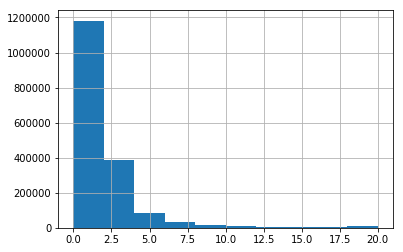

In [26]:
sales_train_ag['item_cnt_month'].hist()

# 2) Обработка признака item_price

In [27]:
sales_train_ag.shape

(1739019, 7)

In [28]:
sales_train_ag.groupby(["date_block_num","shop_id","item_id","month",'year'],as_index=False).sum()[["date_block_num","shop_id","item_id","month",'year',"item_cnt_month"]].shape

(1609123, 6)

Видим, что в течении месяца цена одного товара могла измениться. Агрегируем цену товара как среднюю цену, а колличество товара как сумму

In [33]:
sales_train_ag_m = sales_train_ag.groupby(["date_block_num","shop_id","item_id","month",'year']).aggregate({'item_price': 'mean', 'item_cnt_month': 'sum'}).reset_index()

In [34]:
sales_train_ag_m.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_price
0,0,2,27,1,2013,1.0,2499.0
1,0,2,33,1,2013,1.0,499.0
2,0,2,317,1,2013,1.0,299.0
3,0,2,438,1,2013,1.0,299.0
4,0,2,471,1,2013,2.0,399.0


Посмотрим на динамику изменения цен товаров в разных магазинах

In [39]:
df_price = sales_train_ag_m[['date_block_num','shop_id','item_id','item_price']].pivot_table(index=['shop_id','item_id'], columns='date_block_num', fill_value=-1).reset_index()

In [40]:
df_price.head() #-1 - товар не продавался в этом магазине в этом месяце

shop_id item_id item_price                                   \
date_block_num                          0      1      2      3    4      5   
0                    2      27     2499.0   -1.0   -1.0   -1.0 -1.0   -1.0   
1                    2      30       -1.0   -1.0  359.0   -1.0 -1.0  399.0   
2                    2      31       -1.0  699.0  698.5  699.0 -1.0   -1.0   
3                    2      32       -1.0   -1.0   -1.0   -1.0 -1.0   -1.0   
4                    2      33      499.0   -1.0   -1.0   -1.0 -1.0   -1.0   

                          ...                                               \
date_block_num    6    7  ...   24     25     26     27     28   29     30   
0              -1.0 -1.0  ... -1.0   -1.0   -1.0   -1.0   -1.0 -1.0   -1.0   
1              -1.0 -1.0  ... -1.0   -1.0   -1.0   -1.0   -1.0 -1.0   -1.0   
2              -1.0 -1.0  ... -1.0   -1.0   -1.0   -1.0   -1.0 -1.0   -1.0   
3              -1.0 -1.0  ... -1.0   -1.0  149.0   -1.0   -1.0 -1.0   -1.0   
4              -1.0 -1.0  ... -1.0  199.0   -1.0  199.0  199.0 -1.0  199.0   

                                     
date_block_num     31     32     33  
0                -1.0   -1.0   -1.0  
1                -1.0   -1.0   -1.0  
2                -1.0   -1.0  399.0  
3               149.0   -1.0   -1.0  
4                -1.0  199.0   -1.0  

[5 rows x 36 columns]

In [54]:
col = ['shop_id', 'item_id', '0', '1', '2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19',
           '20','21','22','23','24','25','26','27','28','29','30','31','32','33']
df_price = pd.DataFrame(df_price.values, columns = col)
df_price.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2.0,27.0,2499.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,2.0,30.0,-1.0,-1.0,359.0,-1.0,-1.0,399.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2.0,31.0,-1.0,699.0,698.5,699.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,399.0
3,2.0,32.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,149.0,-1.0,-1.0,-1.0,-1.0,149.0,-1.0,-1.0
4,2.0,33.0,499.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,199.0,-1.0,199.0,199.0,-1.0,199.0,-1.0,199.0,-1.0


Сравним цены на один и тот же товар в разных магазинах

In [56]:
df_price[['item_id','shop_id', '33']].pivot_table(index=['item_id'], columns='shop_id', fill_value=-1).head()#.reset_index()

33                                               ...                 \
shop_id 2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0 12.0  ... 50.0 51.0 52.0   
item_id                                                    ...                  
0.0     -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   -1 -1.0 -1.0 -1.0  ... -1.0   -1 -1.0   
1.0     -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   -1 -1.0 -1.0 -1.0  ... -1.0   -1 -1.0   
2.0     -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   -1 -1.0 -1.0 -1.0  ... -1.0   -1 -1.0   
3.0     -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   -1 -1.0 -1.0 -1.0  ... -1.0   -1 -1.0   
4.0     -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   -1 -1.0 -1.0 -1.0  ... -1.0   -1 -1.0   

                                            
shop_id 53.0 54.0 55.0 56.0 57.0 58.0 59.0  
item_id                                     
0.0     -1.0   -1 -1.0 -1.0 -1.0 -1.0 -1.0  
1.0     -1.0   -1 -1.0 -1.0 -1.0 -1.0 -1.0  
2.0     -1.0   -1 -1.0 -1.0 -1.0 -1.0 -1.0  
3.0     -1.0   -1 -1.0 -1.0 -1.0 -1.0 -1.0  
4.0     -1.0   -1 -1.0 -1.0 -1.0 -1.0 -1.0  

[5 rows x 57 columns]

В тестовом наборе данных нет цен на товары, при этом есть новые товары, которые никогда раньше не продавались. 

Можно попробовать использовать самые последние цены на известные товары, а для неизвестных товаров оценить среднее значении цены категории товара и использовать ее 

# 2) Добавление новых признаков 

## 2.1) Sales_train_ag_m

In [58]:
sales_train_ag_m.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_price
0,0,2,27,1,2013,1.0,2499.0
1,0,2,33,1,2013,1.0,499.0
2,0,2,317,1,2013,1.0,299.0
3,0,2,438,1,2013,1.0,299.0
4,0,2,471,1,2013,2.0,399.0


#### Добавим признаки item_category_id, glob_item_category, city

In [63]:
sales_train_ag_m = sales_train_ag_m.merge(items, how='left')
sales_train_ag_m = sales_train_ag_m.merge(item_categories,how="left")
sales_train_ag_m=  sales_train_ag_m.merge(shops,how="left")

In [64]:
sales_train_ag_m.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_price,item_category_id,glob_item_category,city
0,0,2,27,1,2013,1.0,2499.0,19,Игры,Адыгея
1,0,2,33,1,2013,1.0,499.0,37,Кино,Адыгея
2,0,2,317,1,2013,1.0,299.0,45,Книги,Адыгея
3,0,2,438,1,2013,1.0,299.0,45,Книги,Адыгея
4,0,2,471,1,2013,2.0,399.0,49,Книги,Адыгея


## 2.2) test

In [65]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


### Добавим признаки месяц и год

In [66]:
test.shape

(214200, 2)

In [73]:
test['month'] = pd.Series(np.ones(shape=214200)*11).astype(int)
test['year'] = pd.Series(np.ones(shape=214200)*2015).astype(int)

### Добавим признаки item_category_id, glob_item_category, city

In [75]:
test = test.merge(items, how='left')
test = test.merge(item_categories,how="left")
test =  test.merge(shops,how="left")

In [76]:
test.head()

,shop_id,item_id,month,year,item_category_id,glob_item_category,city
0,5,5037,11,2015,19,Игры,Вологда
1,5,5320,11,2015,55,Музыка,Вологда
2,5,5233,11,2015,19,Игры,Вологда
3,5,5232,11,2015,23,Игры,Вологда
4,5,5268,11,2015,20,Игры,Вологда


# 3) Преобразование категориальных признаков one-hot кодирование

### 3.1) Items

In [77]:
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [79]:
print len(items['item_id'].unique())
print len(items['item_category_id'].unique())

22170
84


In [112]:
from sklearn.preprocessing import OneHotEncoder
enc_item_id = OneHotEncoder(handle_unknown='ignore')
enc_item_id = enc_item_id.fit(items['item_id'].values.reshape(-1, 1))

In [113]:
enc_item_category_id = OneHotEncoder(handle_unknown='ignore')
enc_item_category_id = enc_item_category_id.fit(items['item_category_id'].values.reshape(-1, 1))

### 3.2) Item_categories

In [86]:
item_categories.head()

,item_category_id,glob_item_category
0,0,PC
1,1,Аксессуары
2,2,Аксессуары
3,3,Аксессуары
4,4,Аксессуары


In [114]:
enc_glob_item_category = OneHotEncoder(handle_unknown='ignore')
enc_glob_item_category = enc_glob_item_category.fit(item_categories['glob_item_category'].values.reshape(-1, 1))

### 3.3) shops

In [90]:
shops.head()

,shop_id,city
2,2,Адыгея
3,3,Балашиха
4,4,Волжский
5,5,Вологда
6,6,Воронеж


In [115]:
enc_shop_id = OneHotEncoder(handle_unknown='ignore')
enc_shop_id = enc_shop_id.fit(shops['shop_id'].values.reshape(-1, 1))

enc_city = OneHotEncoder(handle_unknown='ignore')
enc_city = enc_city.fit(shops['city'].values.reshape(-1, 1))

### 3.4) sales_train_ag_m + test (month, year)

In [94]:
all_data = pd.concat([sales_train_ag_m[['month','year']],test[['month','year']]])
all_data.head()

,month,year
0,1,2013
1,1,2013
2,1,2013
3,1,2013
4,1,2013


In [116]:
enc_month = OneHotEncoder(handle_unknown='ignore')
enc_month = enc_month.fit(all_data['month'].values.reshape(-1, 1))

enc_year = OneHotEncoder(handle_unknown='ignore')
enc_year = enc_year.fit(all_data['year'].values.reshape(-1, 1))

# 4) Преобразование sales_train_ag_m выборки

In [97]:
sales_train_ag_m.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_price,item_category_id,glob_item_category,city
0,0,2,27,1,2013,1.0,2499.0,19,Игры,Адыгея
1,0,2,33,1,2013,1.0,499.0,37,Кино,Адыгея
2,0,2,317,1,2013,1.0,299.0,45,Книги,Адыгея
3,0,2,438,1,2013,1.0,299.0,45,Книги,Адыгея
4,0,2,471,1,2013,2.0,399.0,49,Книги,Адыгея


In [98]:
sales_train_ag_m.sort_values(by='date_block_num', inplace=True)

In [101]:
train_df = sales_train_ag_m.drop(['date_block_num','item_price'], axis=1)

In [117]:
train_shop_id = enc_shop_id.transform(train_df['shop_id'].values.reshape(-1, 1))
train_item_id = enc_item_id.transform(train_df['item_id'].values.reshape(-1, 1))
train_month = enc_month.transform(train_df['month'].values.reshape(-1, 1))
train_year = enc_year.transform(train_df['year'].values.reshape(-1, 1))
train_item_category_id = enc_item_category_id.transform(train_df['item_category_id'].values.reshape(-1, 1))
train_glob_item_category = enc_glob_item_category.transform(train_df['glob_item_category'].values.reshape(-1, 1))
train_city = enc_city.transform(train_df['city'].values.reshape(-1, 1))

In [121]:
from scipy.sparse import hstack
X_train = hstack([train_shop_id, train_item_id, train_month, train_year, train_item_category_id, train_glob_item_category, train_city])

In [122]:
X_train.shape

(1609123L, 22372L)

In [126]:
y_train = sales_train_ag_m['item_cnt_month'].astype(int).values

# 5) Преобразование test выборки

In [128]:
test.head()

,shop_id,item_id,month,year,item_category_id,glob_item_category,city
0,5,5037,11,2015,19,Игры,Вологда
1,5,5320,11,2015,55,Музыка,Вологда
2,5,5233,11,2015,19,Игры,Вологда
3,5,5232,11,2015,23,Игры,Вологда
4,5,5268,11,2015,20,Игры,Вологда


In [129]:
test_shop_id = enc_shop_id.transform(test['shop_id'].values.reshape(-1, 1))
test_item_id = enc_item_id.transform(test['item_id'].values.reshape(-1, 1))
test_month = enc_month.transform(test['month'].values.reshape(-1, 1))
test_year = enc_year.transform(test['year'].values.reshape(-1, 1))
test_item_category_id = enc_item_category_id.transform(test['item_category_id'].values.reshape(-1, 1))
test_glob_item_category = enc_glob_item_category.transform(test['glob_item_category'].values.reshape(-1, 1))
test_city = enc_city.transform(test['city'].values.reshape(-1, 1))

In [130]:
X_test = hstack([test_shop_id, test_item_id, test_month, test_year, test_item_category_id, test_glob_item_category, test_city])

In [131]:
X_test.shape

(214200L, 22372L)

# 6) Сохранение данных

In [132]:
import os
import pickle
PATH_TO_DATA = '.\data'
with open(os.path.join(PATH_TO_DATA, 'X_sparse_train.pkl'), 'wb') as X_s_t:
    pickle.dump(X_train, X_s_t, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_sparse_test.pkl'), 'wb') as X_s_test:
    pickle.dump(X_test, X_s_test, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'y_train.pkl'), 'wb') as y_t:
    pickle.dump(y_train, y_t, protocol=2)

In [134]:
sales_train_ag_m.to_csv('.\data\sales_train_ag_m.csv')
test.to_csv('.\data\\test_new.csv')